In [1]:
# from pymatgen.io.vasp.inputs import Incar, Kpoints, Poscar, Potcar, VaspInput
# from pymatgen.core import Structure, Lattice
# from pymatgen.io import vasp
# import pymatgen as mg
import numpy as np
from numpy.linalg import inv
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from random import randrange
from itertools import product, combinations
from collections import defaultdict
import shutil
import os
import re
#import torch
from time import time
from itertools import permutations
from pulp import *
import time
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.stats import t
from fitter import Fitter
from scipy.stats import gamma, pearson3, norm
import numba
from numba import jit
import ipynb_importer
import mail_auto

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

def mpdata_duplicates(seq):
    resultstraintally = defaultdict(list)
    for i,item in enumerate(seq):
        resultstraintally[item].append(i)
    return ((locs) for key,locs in resultstraintally.items() 
                            if len(locs)>1)
def delete_1(a):
    delete, delete_f = [], []
    for i in range(len(a)):
        for s in a[i]:
            if s == 1:
                delete.append(i)
    for i in delete:
        if i not in delete_f:
            delete_f.append(i)
    a = np.delete(a, delete_f, axis = 0)
    return a

def supercell_gen_irre(x_axis, y_axis, z_axis):
    x_axis, y_axis, z_axis = x_axis * 2 + 1, y_axis * 2 + 1, z_axis * 2 + 1
    zero_cell = np.zeros(((x_axis, y_axis, z_axis)))
    for i in range(x_axis):
        for j in range(y_axis):
            for k in range(z_axis):
                if i%2 == 1:
                    zero_cell[i][j][k] = abs(j%2 - k%2)
                elif i%2 == 0:
                    zero_cell[i][j][k] = 1 - abs(j%2 - k%2)
    return zero_cell

#zero_cell = supercell_gen_irre(3, 4, 4)
def second_to_hour(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    print("calc cost: %d:%02d:%02d" % (h, m, s))
    
def supercell_gen(cell_num1):
    atom_pos = cell_num1*2 + 1
    zero_cell = np.zeros(((atom_pos, atom_pos, atom_pos)))
    for i in range(atom_pos):
        for j in range(atom_pos):
            for k in range(atom_pos):
                if i%2 == 1:
                    zero_cell[i][j][k] = abs(j%2 - k%2)
                elif i%2 == 0:
                    zero_cell[i][j][k] = 1 - abs(j%2 - k%2)
    return zero_cell

def gen_crconi(cr_content, co_content, num):
    unit = supercell_gen(num)
    #for x in range(100000):
    ind = [i[0] for i in np.ndenumerate(unit) if i[1] == 1]
    tuple_len = [i for i in range(len(ind))]
    train_size = int(len(tuple_len)*cr_content) + randrange(2)
    co_content = co_content/(1-cr_content)
    ind1, ind23 = train_test_split(tuple_len, test_size = len(tuple_len) - train_size, train_size = train_size)
    train_size_sub = int(len(ind23)*co_content) + randrange(2)
    ind2, ind3 = train_test_split(ind23, test_size = len(ind23) - train_size_sub, train_size = train_size_sub)
    
    num = num * 2
    
    cr_position = np.array([ind[i] for i in ind1])/num
    co_position = np.array([ind[i] for i in ind2])/num
    ni_position = np.array([ind[i] for i in ind3])/num
    
    return cr_position, co_position, ni_position, np.array(ind)/6

def find_overlap(A, B):

    if not A.dtype == B.dtype:
        raise TypeError("A and B must have the same dtype")
    if not A.shape[1:] == B.shape[1:]:
        raise ValueError("the shapes of A and B must be identical apart from "
                         "the row dimension")

    # reshape A and B to 2D arrays. force a copy if neccessary in order to
    # ensure that they are C-contiguous.
    A = np.ascontiguousarray(A.reshape(A.shape[0], -1))
    B = np.ascontiguousarray(B.reshape(B.shape[0], -1))

    # void type that views each row in A and B as a single item
    t = np.dtype((np.void, A.dtype.itemsize * A.shape[1]))

    # use in1d to find rows in A that are also in B
    return np.in1d(A.view(t), B.view(t))

def abs_dis(a, b, target):
    return abs(np.linalg.norm(np.array(a) - np.array(b)) - target)

#spin
def entro_spin(val1, val2, val3):
    len_all = len(val1) + len(val2) + len(val3)
    prob_cr = len(val1)/len_all
    prob_co = len(val2)/len_all
    prob_ni = len(val3)/len_all
    prob_spin = np.array([prob_cr, prob_co, prob_ni])
    entro_spin = -5*np.sum(prob_spin*np.log(prob_spin))
    return entro_spin

#bond
def count_bond(cell_num_recip, num_bond, len_all, *args):
    count_bond = 0
    if len(args) == 1:
        for i1, i2 in combinations(args[0], 2):
            if abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001:
                count_bond += 1
        ideal_bond = (len(args[0])/len_all)**2*num_bond
    elif len(args) == 2:
        for i1 in args[0]:
            for i2 in args[1]:
                if abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001:
                    count_bond += 1
        ideal_bond = 2*(len(args[0])/len_all)*(len(args[1])/len_all)*num_bond
    return count_bond, ideal_bond

def entro_bond(val1, val2, val3, cell_num_recip, num_bond):
    count_bond_list = []
    count_bond_list.append(count_bond(cell_num_recip, val1))
    count_bond_list.append(count_bond(cell_num_recip, val2))
    count_bond_list.append(count_bond(cell_num_recip, val3))
    count_bond_list.append(count_bond(cell_num_recip, val1, val2))
    count_bond_list.append(count_bond(cell_num_recip, val1, val3))
    count_bond_list.append(count_bond(cell_num_recip, val2, val3))
    prob_bond = np.array(count_bond_list)/num_bond
    entro_bond = 6*np.sum(prob_bond*np.log(prob_bond))
    return entro_bond

#tri
def count_2p1(val_2, val_1, cell_num_recip, num_tri, len_all):
    count_bi = 0
    try:
        for i1, i2 in combinations(val_2, 2):
            for i3 in val_1:
                if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)/2) < 0.001 
                    and abs_dis(i3, i2, cell_num_recip*np.sqrt(2)/2) < 0.001 
                    and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)/2) < 0.001):
                #print(i1, i2, i3)
                    count_bi += 1
    except:
        count_bi = 0
    ideal_val1 = len(val_1)/len_all
    ideal_val2 = len(val_2)/len_all
    ideal_prob = 3*(ideal_val2**2)*ideal_val1*num_tri
    
    return count_bi, ideal_prob

#3equal elements
def count_3(val, cell_num_recip, num_tri, len_all):
    count_ter = 0
    try:
        for i1, i2, i3 in combinations(val, 3):
            if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)/2) < 0.001 
                and abs_dis(i3, i2, cell_num_recip*np.sqrt(2)/2) < 0.001 
                and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)/2) < 0.001):
                count_ter += 1
    except:
        count_ter = 0
    ideal_val = len(val)/len_all
    ideal_prob = (ideal_val**3)*num_tri
    
    return count_ter, ideal_prob

def count_1p1p1(val1, val2, val3, cell_num_recip, num_tri, len_all):
    count_tri_1p1p1 = 0
    for i1 in val1:
        for i2 in val2:
            for i3 in val3:
                if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                    and abs_dis(i3, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                    and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)) < 0.001):
                    count_tri_1p1p1 += 1
    ideal_val1 = len(val1)/len_all
    ideal_val2 = len(val2)/len_all
    ideal_val3 = len(val3)/len_all
    ideal_prob = 6*ideal_val1*ideal_val2*ideal_val3*num_tri
    
    return count_tri_1p1p1, ideal_prob

#tetra
#4 equal elements
def count_tetra_4(val, cell_num_recip, num_tetra, len_all):
    count_qua = 0
    for i1, i2, i3, i4 in combinations(val, 4):
        if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001 
            and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)) < 0.001 
            and abs_dis(i1, i4, cell_num_recip*np.sqrt(2)) < 0.001
            and abs_dis(i2, i3, cell_num_recip*np.sqrt(2)) < 0.001
            and abs_dis(i2, i4, cell_num_recip*np.sqrt(2)) < 0.001
            and abs_dis(i3, i4, cell_num_recip*np.sqrt(2)) < 0.001):
            count_qua += 1
    ideal_val = len(val)/len_all
    ideal_prob = ideal_val**4*num_tetra
    return count_qua, ideal_prob

#3p1
def count_tetra_3p1(val1, val2, cell_num_recip, num_tetra, len_all):
    count_tetra = 0
    for i1, i2, i3 in combinations(val1, 3):
        for i4 in val2:
            if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                and abs_dis(i3, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)) < 0.001
                and abs_dis(i1, i4, cell_num_recip*np.sqrt(2)) < 0.001
                and abs_dis(i2, i4, cell_num_recip*np.sqrt(2)) < 0.001
                and abs_dis(i3, i4, cell_num_recip*np.sqrt(2)) < 0.001):
                count_tetra += 1
    ideal_val1 = len(val1)/len_all
    ideal_val2 = len(val2)/len_all
    ideal_prob = 4*(ideal_val1**3)*ideal_val2*num_tetra
    return count_tetra, ideal_prob

#2p2
def count_tetra_2p2(val1, val2, cell_num_recip, num_tetra, len_all):
    count_tetra = 0
    for i1, i2 in combinations(val1, 2):
        for i3, i4 in combinations(val2, 2):
            if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                and abs_dis(i3, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)) < 0.001
                and abs_dis(i1, i4, cell_num_recip*np.sqrt(2)) < 0.001
                and abs_dis(i2, i4, cell_num_recip*np.sqrt(2)) < 0.001
                and abs_dis(i3, i4, cell_num_recip*np.sqrt(2)) < 0.001):
                count_tetra += 1
    ideal_val1 = len(val1)/len_all
    ideal_val2 = len(val2)/len_all
    ideal_prob = 6*(ideal_val1**2)*(ideal_val2**2)*num_tetra
    return count_tetra, ideal_prob

#2p1p1
def count_tetra_2p1p1(val1, val2, val3, cell_num_recip, num_tetra, len_all):
    count_tetra = 0
    for i1, i2 in combinations(val1, 2):
        for i3 in val2:
            for i4 in val3:
                if (abs_dis(i1, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                    and abs_dis(i3, i2, cell_num_recip*np.sqrt(2)) < 0.001 
                    and abs_dis(i1, i3, cell_num_recip*np.sqrt(2)) < 0.001
                    and abs_dis(i1, i4, cell_num_recip*np.sqrt(2)) < 0.001
                    and abs_dis(i2, i4, cell_num_recip*np.sqrt(2)) < 0.001
                    and abs_dis(i3, i4, cell_num_recip*np.sqrt(2)) < 0.001):
                    count_tetra += 1
    ideal_val1 = len(val1)/len_all
    ideal_val2 = len(val2)/len_all
    ideal_val3 = len(val3)/len_all
    ideal_prob = 12*(ideal_val1**2)*ideal_val2*ideal_val3*num_tetra
    return count_tetra, ideal_prob


        
#Cr, Co, Ni {0, 1, -1}
def first_nn_gen(centr, cr_position, co_position, ni_position, ind):
    
    centr_t = np.expand_dims(centr, axis = 0)
    if find_overlap(centr_t, cr_position) == [True]:
        sigma_centr = 0
    elif find_overlap(centr_t, co_position) == [True]:
        sigma_centr = 1
    elif find_overlap(centr_t, ni_position) == [True]:
        sigma_centr = -1
    else:
        print('?')
    first_nn_pair = []
    for i in ind:
        if abs_dis(i, centr, cell_num_recip/2*math.sqrt(2)) < 0.001:
            first_nn_pair.append(i)
    first_nn_pair = np.array(first_nn_pair)
    centr_cr = len([i for i in find_overlap(first_nn_pair, cr_position) if i == True])
    centr_co = len([i for i in find_overlap(first_nn_pair, co_position) if i == True])
    centr_ni = len([i for i in find_overlap(first_nn_pair, ni_position) if i == True])
    return sigma_centr, centr_cr, centr_co, centr_ni, first_nn_pair

def first_cor_func(cr_position, co_position, ni_position, ind):
    fc = 0
    for i in ind:
        if np.min(i-cell_num_recip/2) >= 0:
            sigma_centr, cr_num, co_num, ni_num, first_nn_pair = first_nn_gen(i, 
                                                                              cr_position, 
                                                                              co_position, 
                                                                              ni_position, 
                                                                              ind)
            cor_func = (cpr(sigma_centr, 0)*cr_num 
                        + cpr(sigma_centr, 1)*co_num 
                        + cpr(sigma_centr, -1)*ni_num)
            fc += cor_func
    return fc

def second_nn_gen(centr, cr_position, co_position, ni_position, ind):
    
    centr_t = np.expand_dims(centr, axis = 0)
    if find_overlap(centr_t, cr_position) == [True]:
        sigma_centr = 0
    elif find_overlap(centr_t, co_position) == [True]:
        sigma_centr = 1
    elif find_overlap(centr_t, ni_position) == [True]:
        sigma_centr = -1
    else:
        print('?')
    first_nn_pair = []
    for i in ind:
        if abs_dis(i, centr, cell_num_recip) < 0.001:
            first_nn_pair.append(i)
    first_nn_pair = np.array(first_nn_pair)
    centr_cr = len([i for i in find_overlap(first_nn_pair, cr_position) if i == True])
    centr_co = len([i for i in find_overlap(first_nn_pair, co_position) if i == True])
    centr_ni = len([i for i in find_overlap(first_nn_pair, ni_position) if i == True])
    return sigma_centr, centr_cr, centr_co, centr_ni, first_nn_pair

def third_nn_gen(centr, cr_position, co_position, ni_position, ind):
    
    centr_t = np.expand_dims(centr, axis = 0)
    if find_overlap(centr_t, cr_position) == [True]:
        sigma_centr = 0
    elif find_overlap(centr_t, co_position) == [True]:
        sigma_centr = 1
    elif find_overlap(centr_t, ni_position) == [True]:
        sigma_centr = -1
    else:
        print('?')
    first_nn_pair = []
    for i in ind:
        if abs_dis(i, centr, math.sqrt(3/2)*cell_num_recip) < 0.001:
            first_nn_pair.append(i)
    first_nn_pair = np.array(first_nn_pair)
    centr_cr = len([i for i in find_overlap(first_nn_pair, cr_position) if i == True])
    centr_co = len([i for i in find_overlap(first_nn_pair, co_position) if i == True])
    centr_ni = len([i for i in find_overlap(first_nn_pair, ni_position) if i == True])
    return sigma_centr, centr_cr, centr_co, centr_ni, first_nn_pair

def fourth_nn_gen(centr, cr_position, co_position, ni_position, ind):
    
    centr_t = np.expand_dims(centr, axis = 0)
    if find_overlap(centr_t, cr_position) == [True]:
        sigma_centr = 0
    elif find_overlap(centr_t, co_position) == [True]:
        sigma_centr = 1
    elif find_overlap(centr_t, ni_position) == [True]:
        sigma_centr = -1
    else:
        print('?')
    first_nn_pair = []
    for i in ind:
        if abs_dis(i, centr, math.sqrt(2)*cell_num_recip) < 0.001:
            first_nn_pair.append(i)
    first_nn_pair = np.array(first_nn_pair)
    centr_cr = len([i for i in find_overlap(first_nn_pair, cr_position) if i == True])
    centr_co = len([i for i in find_overlap(first_nn_pair, co_position) if i == True])
    centr_ni = len([i for i in find_overlap(first_nn_pair, ni_position) if i == True])
    return sigma_centr, centr_cr, centr_co, centr_ni, first_nn_pair

def nn_cor_func(cr_position, co_position, ni_position, ind, bond_dis):
    pair_list, cor_fun = [], 0
    for i1, i2 in combinations(ind, 2):
        if (abs_dis(i1, i2, bond_dis) < 0.001):
            pair_list.append([i1, i2])
            
    pair_list = np.array(pair_list)
    
    for pair in pair_list:
        len_cr = overlap_count(pair, cr_position)
        len_co = overlap_count(pair, co_position)
        len_ni = overlap_count(pair, ni_position)
        
        pair_overlap = [len_cr, len_co, len_ni]
        
        if pair_overlap == [2,0,0]:
            cor_func = cpr(0,0)
        elif pair_overlap == [1,1,0]:
            cor_func = cpr(0,1)
        elif pair_overlap == [1,0,1]:
            cor_func = cpr(0,-1)
        elif pair_overlap == [0,2,0]:
            cor_func = cpr(1,1)
        elif pair_overlap == [0,1,1]:
            cor_func = cpr(-1,1)
        elif pair_overlap == [0,0,2]:
            cor_func = cpr(-1,-1)
            
        cor_fun += cor_func
    
    return cor_fun

def ideal_cor_func(cr_content, co_content, bond_num, mode = 'please print man!'):
    ni_content = 1-cr_content-co_content
    
    num_crcr = cr_content**2*bond_num
    num_coco = co_content**2*bond_num
    num_nini = ni_content**2*bond_num
    num_crco = 2*cr_content*co_content*bond_num
    num_coni = 2*co_content*ni_content*bond_num
    num_crni = 2*cr_content*ni_content*bond_num
    
    cor_func = (num_crcr*cpr(0,0)
               +num_coco*cpr(1,1)
               +num_nini*cpr(-1,-1)
               +num_crco*cpr(0,1)
               +num_crni*cpr(0,-1)
               +num_coni*cpr(1,-1))
    if mode == 'please print man!':
        print(f'ideal cor func of Cr{cr_content*100}Co{co_content*100}Ni{ni_content*100}: {cor_func}')
    return cor_func

def second_cor_func(cr_position, co_position, ni_position, ind):
    fc = 0
    for i in ind:
        if np.min(i-cell_num_recip) >= 0:
            sigma_centr, cr_num, co_num, ni_num, first_nn_pair = second_nn_gen(i, 
                                                                              cr_position, 
                                                                              co_position, 
                                                                              ni_position, 
                                                                              ind)
            cor_func = (cpr(sigma_centr, 0)*cr_num 
                        + cpr(sigma_centr, 1)*co_num 
                        + cpr(sigma_centr, -1)*ni_num)
            fc += cor_func
    return fc

sigma_cr, sigma_co, sigma_ni = 0, 1, -1

def pair_pair_cor_func(cr_posiiton, co_position, ni_position, dis1, dis2, ind):
    pair_list, cor_fun = [], 0
    for i1, i2 in combinations(ind, 2):
        if (abs_dis(i1, i2, dis1) < 0.001
            or abs_dis(i1, i2, dis2) < 0.001):
            pair_list.append([i1, i2])
    
    pair_list = np.array(pair_list)
    
    for pair_1, pair_2 in combinations(pair_list, 2):
        if overlap_count(pair_1, pair_2) == 1:
            
            len_cr_1 = overlap_count(pair_1, cr_position)
            len_co_1 = overlap_count(pair_1, co_position)
            len_ni_1 = overlap_count(pair_1, ni_position)
            
            len_cr_2 = overlap_count(pair_2, cr_position)
            len_co_2 = overlap_count(pair_2, co_position)
            len_ni_2 = overlap_count(pair_2, ni_position)
            
            pair_1_overlap = [len_cr_1, len_co_1, len_ni_1]
            pair_2_overlap = [len_cr_2, len_co_2, len_ni_2]
            
            if pair_1_overlap == [2,0,0]:
                cor_func_1 = cpr(0,0)
            elif pair_1_overlap == [1,1,0]:
                cor_func_1 = cpr(0,1)
            elif pair_1_overlap == [1,0,1]:
                cor_func_1 = cpr(0,-1)
            elif pair_1_overlap == [0,2,0]:
                cor_func_1 = cpr(1,1)
            elif pair_1_overlap == [0,1,1]:
                cor_func_1 = cpr(-1,1)
            elif pair_1_overlap == [0,0,2]:
                cor_func_1 = cpr(-1,-1)
                
            if pair_2_overlap == [2,0,0]:
                cor_func_2 = cpr(0,0)
            elif pair_2_overlap == [1,1,0]:
                cor_func_2 = cpr(0,1)
            elif pair_2_overlap == [1,0,1]:
                cor_func_2 = cpr(0,-1)
            elif pair_2_overlap == [0,2,0]:
                cor_func_2 = cpr(1,1)
            elif pair_2_overlap == [0,1,1]:
                cor_func_2 = cpr(-1,1)
            elif pair_2_overlap == [0,0,2]:
                cor_func_2 = cpr(-1,-1)
            
            cor_func_pair = cor_func_1 * cor_func_2
            cor_fun += cor_func_pair
            
    return cor_fun

def nn_cor_func_new(cr_position, co_position, ni_position, ind, bond_dis):
    pair_list, cor_fun = [], 0
    for i1, i2 in combinations(ind, 2):
        if (abs_dis(i1, i2, bond_dis) < 0.001):
            pair = np.array([i1, i2])
            try:
                len_cr_bond = overlap_count(pair, cr_position)
            except:
                len_cr_bond = 0
            try:
                len_co_bond = overlap_count(pair, co_position)
            except:
                len_co_bond = 0
            try:
                len_ni_bond = overlap_count(pair, ni_position)
            except:
                len_ni_bond = 0

            pair_overlap = [len_cr_bond, len_co_bond, len_ni_bond]

            if pair_overlap == [2,0,0]:
                cor_func = cpr(0,0)
            elif pair_overlap == [1,1,0]:
                cor_func = cpr(0,1)
            elif pair_overlap == [1,0,1]:
                cor_func = cpr(0,-1)
            elif pair_overlap == [0,2,0]:
                cor_func = cpr(1,1)
            elif pair_overlap == [0,1,1]:
                cor_func = cpr(-1,1)
            elif pair_overlap == [0,0,2]:
                cor_func = cpr(-1,-1)
            
            cor_fun += cor_func
    
    return cor_fun

def overlap_count(A, B):
    num = len([i for i in find_overlap(A, B) if i == True])
    return num

def phi0(x):
    return 1

def phi1(x):
    return math.sqrt(3/2)*x

def phi2(x):
    return math.sqrt(2)*(3/2*(x**2) - 1)

def cpr(val1, val2):
    basis_1 = [phi1(val1), phi2(val1)]
    basis_2 = [phi1(val2), phi2(val2)]
    cor_func = np.sum(np.outer(basis_1, basis_2))
    return cor_func

def np_move_avg(a, n, mode = 'valid'):
    return(np.convolve(a, np.ones((n,))/n, mode = mode))

def ideal_pair_pair(cr_content, co_content, pair_num):
    cr = cr_content
    co = co_content
    ni = 1 - cr - co
    pair_pair_nn = ((cr**3)*(cpr(0,0)**2)
                 +(co**3)*(cpr(1,1)**2)
                 +(ni**3)*(cpr(-1,-1)**2)
                 +2*cr*cr*co*cpr(0,0)*cpr(0,1)
                 +2*cr*cr*ni*cpr(0,0)*cpr(0,-1)
                 +2*co*co*cr*cpr(1,1)*cpr(1,0)
                 +2*co*co*ni*cpr(1,1)*cpr(1,-1)
                 +2*ni*ni*cr*cpr(-1,-1)*cpr(-1,0)
                 +2*ni*ni*co*cpr(-1,-1)*cpr(-1,1)
                 +cr*co*co*(cpr(0,1)**2)
                 +cr*ni*ni*(cpr(0,-1)**2)
                 +co*cr*cr*(cpr(1,0)**2)
                 +co*ni*ni*(cpr(1,-1)**2)
                 +ni*cr*cr*(cpr(-1,0)**2)
                 +ni*co*co*(cpr(-1,1)**2)
                 +2*cr*co*ni*cpr(0,1)*cpr(0,-1)
                 +2*co*cr*ni*cpr(1,0)*cpr(1,-1)
                 +2*ni*cr*co*cpr(-1,0)*cpr(-1,1))
    
    cor_func_all = pair_pair_nn * pair_num
    
    return cor_func_all

def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()
    return

importing Jupyter notebook from mail_auto.ipynb


$Rot(w, \theta) = $
$\begin{bmatrix}
cos\theta + w_1^2(1-cos\theta) & w_1w_2(1-cos\theta)-w_3cos\theta & w_1w_3(1-cos\theta)+w_2sin\theta\\
w_1w_2(1-cos\theta)+w_3sin\theta & cos\theta+w_2^2(1-cos\theta) & w_2w_3(1-cos\theta)-w_1sin\theta\\
w_1w_3(1-cos\theta)-w_2sin\theta & w_2w_3(1-cos\theta)+w_1sin\theta & cos\theta+w_3^2(1-cos\theta)\\
\end{bmatrix}$
$p'=Rp$

In [4]:
def lexsort(input_list):
    cr_list = np.array(input_list[0])
    cr_list = cr_list[np.lexsort((
        cr_list[:,2], cr_list[:,1], cr_list[:,0]))]

    co_list = np.array(input_list[1])
    co_list = co_list[np.lexsort((
        co_list[:,2], co_list[:,1], co_list[:,0]))]

    ni_list = np.array(input_list[2])
    ni_list = ni_list[np.lexsort((
        ni_list[:,2], ni_list[:,1], ni_list[:,0]))]

    return np.concatenate([cr_list, co_list, ni_list], axis=0).tolist()

def kill_dup_len(input_gen):#kill the dup of complicate list
    origin_mut_whole, origin_mut_test = [], []
    for origin_whole in input_gen:
        if len(origin_mut_whole) == 0:
            origin_mut_whole.append(origin_whole)
            origin_mut_test.append(lexsort(origin_whole))
        else:
            origin_mut_testnorm = np.array(origin_mut_test)-np.array(lexsort(origin_whole))
            origin_mut_testnorm = np.array([np.linalg.norm(i) for i in origin_mut_testnorm])
            if len(origin_mut_testnorm[origin_mut_testnorm < 0.0001]) == 0:
                origin_mut_whole.append(origin_whole)
                origin_mut_test.append(lexsort(origin_whole))
    
    return len(origin_mut_whole)+1

#example, right hand
theta = math.pi/2
axis = np.array([0, 0, 1])
vector = np.array([[1, 1, 1]])

def rot(axis, vector, theta):
    rot_m = np.array([
        [math.cos(theta)+(axis[0]**2)*(1-math.cos(theta)), 
        axis[0]*axis[1]*(1-math.cos(theta))-axis[2]*math.sin(theta),
        axis[0]*axis[2]*(1-math.cos(theta))+axis[1]*math.sin(theta)],

        [axis[0]*axis[1]*(1-math.cos(theta))+axis[2]*math.sin(theta),
        math.cos(theta)+(axis[1]**2)*(1-math.cos(theta)),
        axis[1]*axis[2]*(1-math.cos(theta))-axis[0]*math.sin(theta)],

        [axis[0]*axis[2]*(1-math.cos(theta))-axis[1]*math.sin(theta),
        axis[1]*axis[2]*(1-math.cos(theta))+axis[0]*math.sin(theta),
        math.cos(theta)+(axis[2]**2)*(1-math.cos(theta))]
    ])
    return np.dot(rot_m, vector.T)

def sym_op_1(input):

    cr_ind = np.array(input[0])
    co_ind = np.array(input[1])
    ni_ind = np.array(input[2])
    max_val = np.max(input[3])
    origin_list = []
    origin_list.append(input)
    #108 situation

    #c2 input

    cr_ind_c2x = cr_ind
    cr_ind_c2x[:, 0] = max_val - cr_ind_c2x[:, 0] 
    co_ind_c2x = co_ind
    co_ind_c2x[:, 0] = max_val - co_ind_c2x[:, 0]
    ni_ind_c2x = ni_ind
    ni_ind_c2x[:, 0] = max_val - ni_ind_c2x[:, 0] 
    origin_list_c2x = [cr_ind_c2x.tolist(), co_ind_c2x.tolist(), ni_ind_c2x.tolist(), 
                       np.concatenate([cr_ind_c2x, co_ind_c2x, ni_ind_c2x], axis=0).tolist()]
    origin_list.append(origin_list_c2x)

    cr_ind_c2y = cr_ind
    cr_ind_c2y[:, 1] = max_val - cr_ind_c2y[:, 1] 
    co_ind_c2y = co_ind
    co_ind_c2y[:, 1] = max_val - co_ind_c2y[:, 1]
    ni_ind_c2y = ni_ind
    ni_ind_c2y[:, 1] = max_val - ni_ind_c2y[:, 1]
    origin_list_c2y = [cr_ind_c2y.tolist(), co_ind_c2y.tolist(), ni_ind_c2y.tolist(), 
                       np.concatenate([cr_ind_c2y, co_ind_c2y, ni_ind_c2y], axis=0).tolist()]
    origin_list.append(origin_list_c2y)


    cr_ind_c2z = cr_ind
    cr_ind_c2z[:, 2] = max_val - cr_ind_c2z[:, 2] 
    co_ind_c2z = co_ind
    co_ind_c2z[:, 2] = max_val - co_ind_c2z[:, 2]
    ni_ind_c2z = ni_ind
    ni_ind_c2z[:, 2] = max_val - ni_ind_c2z[:, 2]
    origin_list_c2z = [cr_ind_c2z.tolist(), co_ind_c2z.tolist(), ni_ind_c2z.tolist(), 
                       np.concatenate([cr_ind_c2z, co_ind_c2z, ni_ind_c2z], axis=0).tolist()]
    origin_list.append(origin_list_c2z)

    cr_ind_c2xm = cr_ind
    cr_ind_c2xm[:, 0] = max_val - cr_ind_c2xm[:, 0]
    cr_ind_c2xm[:, 1] = max_val - cr_ind_c2xm[:, 1]
    co_ind_c2xm = co_ind
    co_ind_c2xm[:, 0] = max_val - co_ind_c2xm[:, 0]
    co_ind_c2xm[:, 1] = max_val - co_ind_c2xm[:, 1]
    ni_ind_c2xm = ni_ind
    ni_ind_c2xm[:, 0] = max_val - ni_ind_c2xm[:, 0]
    ni_ind_c2xm[:, 1] = max_val - ni_ind_c2xm[:, 1]
    origin_list_c2xm = [cr_ind_c2xm.tolist(), co_ind_c2xm.tolist(), ni_ind_c2xm.tolist(), 
                       np.concatenate([cr_ind_c2xm, co_ind_c2xm, ni_ind_c2xm], axis=0).tolist()]
    origin_list.append(origin_list_c2xm)

    cr_ind_c2ym = cr_ind
    cr_ind_c2ym[:, 2] = max_val - cr_ind_c2ym[:, 2]
    cr_ind_c2ym[:, 1] = max_val - cr_ind_c2ym[:, 1]
    co_ind_c2ym = co_ind
    co_ind_c2ym[:, 2] = max_val - co_ind_c2ym[:, 2]
    co_ind_c2ym[:, 1] = max_val - co_ind_c2ym[:, 1]
    ni_ind_c2ym = ni_ind
    ni_ind_c2ym[:, 2] = max_val - ni_ind_c2ym[:, 2]
    ni_ind_c2ym[:, 1] = max_val - ni_ind_c2ym[:, 1]
    origin_list_c2ym = [cr_ind_c2ym.tolist(), co_ind_c2ym.tolist(), ni_ind_c2ym.tolist(), 
                       np.concatenate([cr_ind_c2ym, co_ind_c2ym, ni_ind_c2ym], axis=0).tolist()]
    origin_list.append(origin_list_c2ym)


    cr_ind_c2zm = cr_ind
    cr_ind_c2zm[:, 2] = max_val - cr_ind_c2zm[:, 2]
    cr_ind_c2zm[:, 0] = max_val - cr_ind_c2zm[:, 0]
    co_ind_c2zm = co_ind
    co_ind_c2zm[:, 2] = max_val - co_ind_c2zm[:, 2]
    co_ind_c2zm[:, 0] = max_val - co_ind_c2zm[:, 0]
    ni_ind_c2zm = ni_ind
    ni_ind_c2zm[:, 2] = max_val - ni_ind_c2zm[:, 2]
    ni_ind_c2zm[:, 0] = max_val - ni_ind_c2zm[:, 0]
    origin_list_c2zm = [cr_ind_c2zm.tolist(), co_ind_c2zm.tolist(), ni_ind_c2zm.tolist(), 
                       np.concatenate([cr_ind_c2zm, co_ind_c2zm, ni_ind_c2zm], axis=0).tolist()]
    origin_list.append(origin_list_c2zm)
    return origin_list

def sym_op(input):#a single config

    cr_ind = np.array(input[0])
    len_cr = len(cr_ind)
    co_ind = np.array(input[1])
    len_co = len(co_ind)
    ni_ind = np.array(input[2])
    len_ni = len(ni_ind)
    ind_raw = np.array(input[3])
    max_val = np.round(np.max(input[3]), decimals=15)
    x_axis = np.array([1,0,0])
    y_axis = np.array([0,1,0])
    z_axis = np.array([0,0,1])
    pi = math.pi
    origin_list = []
    origin_list.append(input)
    #108 situation
    #c4, x9
    input_c4x1 = np.round(rot(x_axis, ind_raw, pi/2), decimals=15).T
    input_c4x1[:,1] += max_val
    input_c4x1 = input_c4x1.tolist()
    origin_list.append([input_c4x1[:len_cr], input_c4x1[len_cr:len_cr+len_co], input_c4x1[len_cr+len_co:], input_c4x1])

    input_c4x2 = np.round(rot(x_axis, ind_raw, pi), decimals=15).T
    input_c4x2[:,1] += max_val
    input_c4x2[:,2] += max_val
    input_c4x2 = input_c4x2.tolist()
    origin_list.append([input_c4x2[:len_cr], input_c4x2[len_cr:len_cr+len_co], input_c4x2[len_cr+len_co:], input_c4x2])

    input_c4x3 = np.round(rot(x_axis, ind_raw, pi*3/2), decimals=15).T
    input_c4x3[:,2] += max_val
    input_c4x3 = input_c4x3.tolist()
    origin_list.append([input_c4x3[:len_cr], input_c4x3[len_cr:len_cr+len_co], input_c4x3[len_cr+len_co:], input_c4x3])

    input_c4y1 = np.round(rot(y_axis, ind_raw, pi/2), decimals=15).T
    input_c4y1[:,2] += max_val
    input_c4y1 = input_c4y1.tolist()
    origin_list.append([input_c4y1[:len_cr], input_c4y1[len_cr:len_cr+len_co], input_c4y1[len_cr+len_co:], input_c4y1])

    input_c4y2 = np.round(rot(y_axis, ind_raw, pi), decimals=15).T
    input_c4y2[:,0] += max_val
    input_c4y2[:,2] += max_val
    input_c4y2 = input_c4y2.tolist()
    origin_list.append([input_c4y2[:len_cr], input_c4y2[len_cr:len_cr+len_co], input_c4y2[len_cr+len_co:], input_c4y2])

    input_c4y3 = np.round(rot(y_axis, ind_raw, pi*3/2), decimals=15).T
    input_c4y3[:,0] += max_val
    input_c4y3 = input_c4y3.tolist()
    origin_list.append([input_c4y3[:len_cr], input_c4y3[len_cr:len_cr+len_co], input_c4y3[len_cr+len_co:], input_c4y3])

    input_c4z1 = np.round(rot(z_axis, ind_raw, pi/2), decimals=15).T
    input_c4z1[:,0] += max_val
    input_c4z1 = input_c4z1.tolist()
    origin_list.append([input_c4z1[:len_cr], input_c4z1[len_cr:len_cr+len_co], input_c4z1[len_cr+len_co:], input_c4z1])

    input_c4z2 = np.round(rot(z_axis, ind_raw, pi), decimals=15).T
    input_c4z2[:,0] += max_val
    input_c4z2[:,1] += max_val
    input_c4z2 = input_c4z2.tolist()
    origin_list.append([input_c4z2[:len_cr], input_c4z2[len_cr:len_cr+len_co], input_c4z2[len_cr+len_co:], input_c4z2])

    input_c4z3 = np.round(rot(z_axis, ind_raw, pi*3/2), decimals=15).T
    input_c4z3[:,1] += max_val
    input_c4z3 = input_c4z3.tolist()
    origin_list.append([input_c4z3[:len_cr], input_c4z3[len_cr:len_cr+len_co], input_c4z3[len_cr+len_co:], input_c4z3])

    #c2, x3
    input_c2x = ind_raw
    input_c2x[:,0] = max_val - input_c2x[:,0]
    input_c2x = input_c2x.tolist()
    origin_list.append([input_c2x[:len_cr], input_c2x[len_cr:len_cr+len_co], input_c2x[len_cr+len_co:], input_c2x])

    # input_c2xt = ind_raw
    # input_c2xt[:,0] = max_val - input_c2xt[:,0]
    # input_c2xt[:,2] = max_val - input_c2xt[:,2]
    # input_c2xt = input_c2xt.tolist()
    # origin_list.append([input_c2xt[:len_cr], input_c2xt[len_cr:len_cr+len_co], input_c2xt[len_cr+len_co:], input_c2xt])

    input_c2y = ind_raw
    input_c2y[:,1] = max_val - input_c2y[:,1]
    input_c2y = input_c2y.tolist()
    origin_list.append([input_c2y[:len_cr], input_c2y[len_cr:len_cr+len_co], input_c2y[len_cr+len_co:], input_c2y])

    # input_c2yt = ind_raw
    # input_c2yt[:,1] = max_val - input_c2yt[:,1]
    # input_c2yt[:,2] = max_val - input_c2yt[:,2]
    # input_c2yt = input_c2yt.tolist()
    # origin_list.append([input_c2yt[:len_cr], input_c2yt[len_cr:len_cr+len_co], input_c2yt[len_cr+len_co:], input_c2yt])

    input_c2z = ind_raw
    input_c2z[:,2] = max_val - input_c2z[:,2]
    input_c2z = input_c2z.tolist()
    origin_list.append([input_c2z[:len_cr], input_c2z[len_cr:len_cr+len_co], input_c2z[len_cr+len_co:], input_c2z])

    # input_c2zt = ind_raw
    # input_c2zt[:,1] = max_val - input_c2zt[:,1]
    # input_c2zt[:,2] = max_val - input_c2zt[:,2]
    # input_c2zt = input_c2zt.tolist()
    # origin_list.append([input_c2zt[:len_cr], input_c2zt[len_cr:len_cr+len_co], input_c2zt[len_cr+len_co:], input_c2zt])

    #c3
    ind_rawx = np.expand_dims(ind_raw[:, 0], axis=1)
    ind_rawy = np.expand_dims(ind_raw[:, 1], axis=1)
    ind_rawz = np.expand_dims(ind_raw[:, 2], axis=1)

    ind_rawt = max_val - ind_raw
    origin_list.append([ind_rawt[:len_cr], ind_rawt[len_cr:len_cr+len_co], ind_rawt[len_cr+len_co:], ind_rawt])

    ind_c31 = np.concatenate([ind_rawx, ind_rawz, ind_rawy], axis=1).tolist()
    origin_list.append([ind_c31[:len_cr], ind_c31[len_cr:len_cr+len_co], ind_c31[len_cr+len_co:], ind_c31])

    ind_c31t = max_val - ind_c31
    origin_list.append([ind_c31t[:len_cr], ind_c31t[len_cr:len_cr+len_co], ind_c31t[len_cr+len_co:], ind_c31t])

    ind_c32 = np.concatenate([ind_rawy, ind_rawz, ind_rawx], axis=1).tolist()
    origin_list.append([ind_c32[:len_cr], ind_c32[len_cr:len_cr+len_co], ind_c32[len_cr+len_co:], ind_c32])

    ind_c32t = max_val - ind_c32
    origin_list.append([ind_c32t[:len_cr], ind_c32t[len_cr:len_cr+len_co], ind_c32t[len_cr+len_co:], ind_c32t])

    ind_c33 = np.concatenate([ind_rawy, ind_rawx, ind_rawz], axis=1).tolist()
    origin_list.append([ind_c33[:len_cr], ind_c33[len_cr:len_cr+len_co], ind_c33[len_cr+len_co:], ind_c33])

    ind_c33t = max_val - ind_c33
    origin_list.append([ind_c33t[:len_cr], ind_c33t[len_cr:len_cr+len_co], ind_c33t[len_cr+len_co:], ind_c33t])

    ind_c34 = np.concatenate([ind_rawz, ind_rawy, ind_rawx], axis=1).tolist()
    origin_list.append([ind_c34[:len_cr], ind_c34[len_cr:len_cr+len_co], ind_c34[len_cr+len_co:], ind_c34])

    ind_c34t = max_val - ind_c34
    origin_list.append([ind_c34t[:len_cr], ind_c34t[len_cr:len_cr+len_co], ind_c34t[len_cr+len_co:], ind_c34t])

    ind_c35 = np.concatenate([ind_rawz, ind_rawx, ind_rawy], axis=1).tolist()
    origin_list.append([ind_c35[:len_cr], ind_c35[len_cr:len_cr+len_co], ind_c35[len_cr+len_co:], ind_c35])

    ind_c35t = max_val - ind_c35
    origin_list.append([ind_c35t[:len_cr], ind_c35t[len_cr:len_cr+len_co], ind_c35t[len_cr+len_co:], ind_c35t])

    return origin_list

In [20]:
%matplotlib widget
origin_c2 = sym_op(origin_list[5])
# draw_3d(origin_c2[-1][3])
print(len(origin_c2))
print(kill_dup_len(origin_c2))

NameError: name 'sym_op' is not defined

In [194]:
origin_test = [
    [[0,0,0],
     [1/2,1/2,0],
     [1,0,0],
     [0,1,0],
     [1,1,0]],
    
    [[1/2,0,1/2],
     [1,1/2,1/2],
     [1/2,1,1/2],
     [0,1/2,1/2]],

    [[0,0,1],
     [1,0,1],
     [1/2,1/2,1],
     [0,1,1],
     [1,1,1]],

    [[0,0,0],
     [1/2,1/2,0],
     [1,0,0],
     [0,1,0],
     [1,1,0],
     [1/2,0,1/2],
     [1,1/2,1/2],
     [1/2,1,1/2],
     [0,1/2,1/2],
     [0,0,1],
     [1,0,1],
     [1/2,1/2,1],
     [0,1,1],
     [1,1,1]]
]

origin_c2 = sym_op(origin_test)
# draw_3d(origin_c2[0][3])
print(len(origin_c2))
print(kill_dup_len(origin_c2))

24
7


In [ ]:
origin_list = []

for i in range(len(cr_position_val)):
    ind_cr = cr_position_val[i]
    ind_co = co_position_val[i]
    ind_ni = ni_position_val[i]
    ind_raw = np.concatenate([ind_cr, ind_co, ind_ni], axis = 0)
    origin_list.append([ind_cr.tolist(), ind_co.tolist(), ind_ni.tolist(), ind_raw.tolist()])

# ind_raw[np.lexsort((ind_raw[:,2], ind_raw[:,1], ind_raw[:,0]))]
len(origin_list)

12

In [6]:
#Using 108 atoms, effe sturc ~ 10%, 1.5h/1000 effestruc.
start = time.time()
cor_func_fir, cor_func_sec, cor_func_pairs = [], [], []
cor_func_thr, cor_func_for = [], []
cr_position_val, co_position_val, ni_position_val = [], [], []
cor_func_12, cor_func_13, cor_func_14 = [], [], []
cor_func_23, cor_func_24, cor_func_34 = [], [], []
cr_content, co_content = 1/3, 1/3
true_num = 108
cell_num_recip = 1/3
ni_content = 1 - cr_content - co_content

for i in range(10):
    cr_position1, co_position1, ni_position1, ind1 = gen_crconi(cr_content, co_content, 3)
    cr_position = delete_1(cr_position1)
    co_position = delete_1(co_position1)
    ni_position = delete_1(ni_position1)
    var_num = ((len(cr_position)-cr_content*true_num)**2+(len(co_position)-co_content*true_num)**2+(len(ni_position)-ni_content*true_num)**2)/3
    ind = np.concatenate([cr_position, co_position, ni_position],
                          axis = 0)
    if var_num <= 2/3:
        origin_list = [cr_position.tolist(), co_position.tolist(), ni_position.tolist(), ind.tolist()]
        n_sym = kill_dup_len(sym_op(origin_list))
        cor_func_val_1 = nn_cor_func_new(cr_position, co_position, ni_position, ind, 1/6*math.sqrt(2))/n_sym
        cor_func_val_2 = nn_cor_func_new(cr_position, co_position, ni_position, ind, 1/3)/n_sym
        cor_func_val_3 = nn_cor_func_new(cr_position, co_position, ni_position, ind, 1/3*math.sqrt(3/2))/n_sym
        cor_func_val_4 = nn_cor_func_new(cr_position, co_position, ni_position, ind, 1/3*math.sqrt(2))/n_sym
        # cor_func_val_12 = pair_pair_cor_func(cr_position, co_position, ni_position, 1/6*math.sqrt(2), 1/3, ind)
        cor_func_fir.append(round(cor_func_val_1, 3))
        cor_func_sec.append(round(cor_func_val_2, 3))
        cor_func_thr.append(round(cor_func_val_3, 3))
        cor_func_for.append(round(cor_func_val_4, 3))
        # cor_func_12.append(round(cor_func_val_12, 3))
        cr_position_val.append(cr_position)
        co_position_val.append(co_position)
        ni_position_val.append(ni_position)

ideal_fir = ideal_cor_func(cr_content, co_content, 450)
ideal_sec = ideal_cor_func(cr_content, co_content, 216)
ideal_thr = ideal_cor_func(cr_content, co_content, 600)
ideal_for = ideal_cor_func(cr_content, co_content, 288)
# ideal_12 = ideal_pair_pair(cr_content, co_content, 1849)
# ideal_13 = ideal_pair_pair(cr_content, co_content, 5778)
# ideal_14 = ideal_pair_pair(cr_content, co_content, 2518)
# ideal_23 = ideal_pair_pair(cr_content, co_content, 2551)
# ideal_24 = ideal_pair_pair(cr_content, co_content, 1248)
# ideal_34 = ideal_pair_pair(cr_content, co_content, 3630)

print(f'lenth of effecient struc: {len(cor_func_fir)}')
content = f'job MSAD rough comp. Cr{int(cr_content*100)}Co{int(co_content*100)}Ni{int(ni_content*100)} complete.\n'
# mail_auto.auto_mail(content)
end = time.time()
second_to_hour(end - start)

ideal cor func of Cr33.33333333333333Co33.33333333333333Ni33.33333333333334: 2.842170943040401e-14
ideal cor func of Cr33.33333333333333Co33.33333333333333Ni33.33333333333334: -7.105427357601002e-15
ideal cor func of Cr33.33333333333333Co33.33333333333333Ni33.33333333333334: -8.526512829121202e-14
ideal cor func of Cr33.33333333333333Co33.33333333333333Ni33.33333333333334: -2.842170943040401e-14
lenth of effecient struc: 2
calc cost: 0:00:01


In [51]:
cor_3333_fir = cor_3333[:,0]
cor_3333_sec = cor_3333[:,1]
cor_3333_thr = cor_3333[:,2]
cor_3333_for = cor_3333[:,3]

In [52]:
ideal_cor_func(1/3, 1/3, 450)/23

ideal cor func of Cr33.33333333333333Co33.33333333333333Ni33.33333333333334: 2.842170943040401e-14


1.2357264969740872e-15

{'norm': (-0.17150713503380582, 1.254860295563612)}


,sumsquare_error,aic,bic,kl_div
norm,0.001424,915.150743,-3.552948e+06,inf


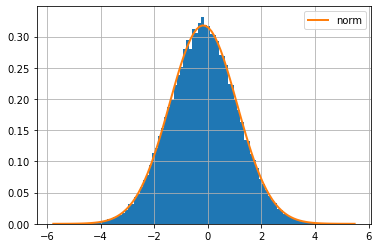

In [54]:
%matplotlib inline
valy_pair = np.array([round(i, 3) for i in cor_3333_sec])
f_pair = Fitter(valy_pair, distributions = ['norm'], timeout = 1500)
f_pair.fit()

print(f_pair.get_best())
f_pair.summary()

In [13]:
cr_positionk, co_positionk, ni_positionk, indk = gen_crconi(cr_content, co_content, 3)
cr_positionk = delete_1(cr_positionk)
co_positionk = delete_1(co_positionk)
ni_positionk = delete_1(ni_positionk)
indkk = np.concatenate([cr_positionk, co_positionk, ni_positionk],
                      axis = 0)

def count_pair_pair_cor_12(cr_position, co_position, ni_position, ind):
    pair_list_1_1, cor_fun = [], 0
    count1_1, count1_2, count2_2 = 0,0,0
    for i1, i2 in combinations(ind, 2):
        if (abs_dis(i1, i2, math.sqrt(2)/6) < 0.0005
            or abs_dis(i1, i2, 1/3) < 0.0005):
            pair_list_1_1.append([i1, i2])
    
    pair_list_1_1 = np.array(pair_list_1_1)
    
    for pair_1, pair_2 in combinations(pair_list_1_1, 2):
        if overlap_count(pair_1, pair_2) == 1:
            if (abs_dis(pair_1[0], pair_1[1], math.sqrt(2)/6) < 0.001
                and abs_dis(pair_2[0], pair_2[1], math.sqrt(2)/6) < 0.001):
                count1_1 += 1
            elif (abs_dis(pair_1[0], pair_1[1], 1/3) < 0.001
               and abs_dis(pair_2[0], pair_2[1], 1/3) < 0.001):
                count2_2 += 1
            elif (abs_dis(pair_1[0], pair_1[1], math.sqrt(2)/6) < 0.001
               and abs_dis(pair_2[0], pair_2[1], 1/3) < 0.001):
                count1_2 += 1

    return count1_1, count2_2, count1_2

def count_pair_pair_cor_13(cr_position, co_position, ni_position, ind):
    pair_list_1_1, cor_fun = [], 0
    count1_3, count3_3, count1_1 = 0,0,0
    for i1, i2 in combinations(ind, 2):
        if (abs_dis(i1, i2, 1/3*math.sqrt(3/2)) < 0.001
            or abs_dis(i1, i2, math.sqrt(2)/6) < 0.001):
            pair_list_1_1.append([i1, i2])
    
    pair_list_1_1 = np.array(pair_list_1_1)
    
    for pair_1, pair_2 in combinations(pair_list_1_1, 2):
        if overlap_count(pair_1, pair_2) == 1:
            if (abs_dis(pair_1[0], pair_1[1], 1/3*math.sqrt(3/2)) < 0.001
                and abs_dis(pair_2[0], pair_2[1], math.sqrt(2)/6) < 0.001):
                count1_3 += 1
            elif (abs_dis(pair_1[0], pair_1[1], 1/3*math.sqrt(3/2)) < 0.001
               and abs_dis(pair_2[0], pair_2[1], 1/3*math.sqrt(3/2)) < 0.001):
                count3_3 += 1
            elif (abs_dis(pair_1[0], pair_1[1], math.sqrt(2)/6) < 0.001
               and abs_dis(pair_2[0], pair_2[1], math.sqrt(2)/6) < 0.001):
                count1_1 += 1

    return count1_3, count1_1, count3_3

count_pair_pair_cor_12(cr_positionk, co_positionk, ni_positionk, indkk)

(3708, 684, 1855)

In [ ]:
np.save('C:/Users/yaoho/OneDrive - Kyoto University/Project/MSAD/distrib_cor_func/weight_disturb/eeee/eeee3_1.npy', cor_func_fir)
np.save('C:/Users/yaoho/OneDrive - Kyoto University/Project/MSAD/distrib_cor_func/weight_disturb/eeee/eeee3_2.npy', cor_func_sec)
np.save('C:/Users/yaoho/OneDrive - Kyoto University/Project/MSAD/distrib_cor_func/weight_disturb/eeee/eeee3_3.npy', cor_func_pairs)
np.save('C:/Users/yaoho/OneDrive - Kyoto University/Project/MSAD/distrib_cor_func/weight_disturb/eeee/eeee3_cr.npy', cr_position_val)
np.save('C:/Users/yaoho/OneDrive - Kyoto University/Project/MSAD/distrib_cor_func/weight_disturb/eeee/eeee3_co.npy', co_position_val)
np.save('C:/Users/yaoho/OneDrive - Kyoto University/Project/MSAD/distrib_cor_func/weight_disturb/eeee/eeee3_ni.npy', ni_position_val)

In [12]:
cor_func_pairs_fit = np.array([round(i, -2) for i in cor_func_12])

dup_count = []
for i in list(cor_func_pairs_fit):
    if list(cor_func_pairs_fit).count(i) > 1:
        dup_count.append([i, list(cor_func_pairs_fit).count(i)])

dup_count = np.array(dup_count)
dup_count_uni = np.unique(dup_count, axis = 0)
dup_count_uni_dupsort = dup_count_uni[dup_count_uni[:, 1].argsort()]
dup_count_uni_valsort = dup_count_uni[dup_count_uni[:, 0].argsort()]

{'gamma': (0.7578182188862141, -67.44700000000002, 179.4613370674785)}


,sumsquare_error,aic,bic,kl_div
gamma,0.001533,1406.345668,-170.236336,inf
pearson3,0.001577,1382.827264,-169.702240,inf
norm,0.001669,1338.359908,-171.574302,inf


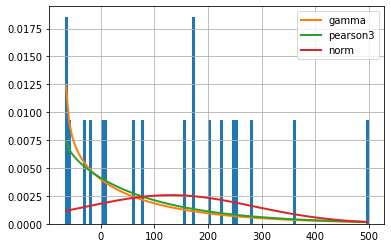

In [118]:
valy_pair = np.array([round(i, 3) for i in cor_func_12])
f_pair = Fitter(valy_pair, distributions = ['gamma', 'pearson3', 'norm'], timeout = 1500)
f_pair.fit()

print(f_pair.get_best())
f_pair.summary()

In [15]:
ideal_12

2260.0157715490914

In [16]:
valx = np.linspace(0, 4000, 10000)
valy = pearson3(0.9824548169443372, 4369.885623686765, 1975.588825412395).pdf(valx)
mean_pair = [i for i, j in zip(valx, valy) if j == np.max(valy)][0]
mean_pair

3399.539953995399

In [79]:
#Average method
num_coni, num_cr3 = [], []
#filting i, j in lowest district

x = [[i, j, k, l] for i, j, k, l in zip(cor_func_fir, cor_func_sec, cor_func_thr, cor_func_for) if (
    abs(i/ideal_fir - 1) <= 1 
    and abs(j/ideal_sec - 1) <= 1
    and abs(k/ideal_thr - 1) <= 1
    and abs(l/ideal_for - 1) <= 1)]

#figuring out index of i, j
x_index = [cor_func_fir.index(i) for i, j, k, l in zip(cor_func_fir, cor_func_sec, cor_func_thr, 
                                                                cor_func_for) if (
    abs(i/ideal_fir - 1) <= 1 
    and abs(j/ideal_sec - 1) <= 1
    and abs(k/ideal_thr - 1) <= 1
    and abs(l/ideal_for - 1) <= 1)]

for ind in x_index:
    num_coni.append(count_2p1(co_position_val[ind], ni_position_val[ind], 1/3, 500, 108)[0])
    num_cr3.append(count_3(cr_position_val[ind], 1/3, 500, 108)[0])

num_coni_ideal = 3*(co_content**2)*ni_content*500
num_crcr_ideal = (cr_content**3)*500
    
x = np.array(x)
num_coni_var = abs(np.array(num_coni) - num_coni_ideal)
num_cr3_var = abs(np.array(num_cr3) - num_crcr_ideal)
num_coni_var = np.expand_dims(np.array(num_coni_var), axis = 0)
num_cr3_var = np.expand_dims(np.array(num_cr3_var), axis = 0)

x_index = np.expand_dims(np.array(x_index), axis = 0)
multi_ave = np.concatenate([x_index.T, x, num_coni_var.T, num_cr3_var.T], axis = 1)
var_mul = multi_ave[:,5]*multi_ave[:,6]
multi_ave = np.concatenate([multi_ave, np.expand_dims(np.array(var_mul), axis = 0).T], axis = 1)
multi_ave = multi_ave[multi_ave[:, 7].argsort()]
multi_ave

array([[10.     , 47.047  , 16.019  , 72.26   , 23.454  ,  0.1875 ,
         0.5    ,  0.09375],
       [16.     , 58.072  , 16.833  , 52.732  , 30.887  ,  0.8125 ,
         0.5    ,  0.40625],
       [ 4.     , 43.683  , 39.704  , 65.475  , 29.276  ,  0.1875 ,
         4.5    ,  0.84375],
       [ 0.     , 42.625  , 13.204  , 44.529  , 29.258  ,  0.1875 ,
         7.5    ,  1.40625],
       [18.     , 52.706  , 30.466  , 60.492  , 28.634  ,  0.1875 ,
         9.5    ,  1.78125],
       [ 5.     , 39.553  , 24.84   , 64.571  , 15.118  ,  0.1875 ,
         9.5    ,  1.78125],
       [17.     , 33.722  , 20.345  , 62.519  , 29.479  ,  0.1875 ,
        10.5    ,  1.96875],
       [ 3.     , 39.563  , 18.445  , 54.968  , 25.641  ,  0.1875 ,
        14.5    ,  2.71875],
       [ 7.     , 49.809  , 19.998  , 68.332  , 32.081  ,  0.1875 ,
        15.5    ,  2.90625],
       [12.     , 53.196  , 14.29   , 42.668  , 31.729  ,  0.1875 ,
        16.5    ,  3.09375],
       [ 1.     , 47.037  , 19

In [8]:
class genetic:
    def __init__(self, sample, cr_content, co_content):
        self.cr_pos = sample[0]
        self.co_pos = sample[1]
        self.ni_pos = sample[2]
        self.ind = sample[3]
        
        self.ideal_fir = ideal_cor_func(cr_content, co_content, 450, mode = 'dont print bro')
        self.ideal_sec = ideal_cor_func(cr_content, co_content, 216, mode = 'dont print bro')
        self.ideal_thr = ideal_cor_func(cr_content, co_content, 600, mode = 'dont print bro')
        self.ideal_for = ideal_cor_func(cr_content, co_content, 288, mode = 'dont print bro')
        self.ideal_fiv = ideal_cor_func(cr_content, co_content, 540, mode = 'dont print bro')
        self.ideal_six = ideal_cor_func(cr_content, co_content, 128, mode = 'dont print bro')
        self.num_coni_ideal = 3*(co_content**2)*(1-cr_content-co_content)*500
        self.num_crcr_ideal = (cr_content**3)*500
        
        self.ideal_partial_fir = ideal_cor_func(cr_content, co_content, 108, mode = 'dont print bro')
        self.ideal_partial_sec = ideal_cor_func(cr_content, co_content, 48, mode = 'dont print bro')
        self.ideal_partial_thr = ideal_cor_func(cr_content, co_content, 108, mode = 'dont print bro')
        self.ideal_partial_for = ideal_cor_func(cr_content, co_content, 48, mode = 'dont print bro')
        self.ideal_partial_fiv = ideal_cor_func(cr_content, co_content, 72, mode = 'dont print bro')
        self.ideal_partial_six = ideal_cor_func(cr_content, co_content, 16, mode = 'dont print bro')
        self.num_coni_ideal_partial = 3*(co_content**2)*(1-cr_content-co_content)*108
        self.num_crcr_ideal_partial = (cr_content**3)*108
        
#[cr_pos, co_pos, ni_pos, ind]
    def mutation(self, repeat_time = 6):
        point_choose = []
        ind_raw = self.ind
        len_cr = len(self.cr_pos)
        len_co = len(self.co_pos)
        len_ni = len(self.ni_pos)
        len_s = len(ind_raw)
        for time in range(repeat_time):
            if np.random.randint(3) >= 1:
                point_3_ind = np.random.randint(len_s)
                point_4_ind = np.random.randint(len_s)
                point_3 = ind_raw[point_3_ind].copy()
                point_4 = ind_raw[point_4_ind].copy()
                ind_raw[point_3_ind] = point_4
                ind_raw[point_4_ind] = point_3
            
        cr_pos_mut = ind_raw[0:len_cr]
        co_pos_mut = ind_raw[len_cr:len_cr+len_co]
        ni_pos_mut = ind_raw[len_cr+len_co:len_cr+len_co+len_ni]
        mut_gen = [cr_pos_mut, co_pos_mut, ni_pos_mut, ind_raw]
        try:
            mut_gen = mut_gen.tolist()
        except:
            mut_gen = mut_gen
            
        return mut_gen
    
    def mutation_partial(self, repeat_time = 2):
        point_choose = []
        ind_raw = self.ind
        len_cr = len(self.cr_pos)
        len_co = len(self.co_pos)
        len_ni = len(self.ni_pos)
        len_s = len(ind_raw)
        
        for time in range(repeat_time):
            point_1_ind = np.random.randint(len_s)
            point_2_ind = np.random.randint(len_s)
            point_1 = ind_raw[point_1_ind].copy()
            point_2 = ind_raw[point_2_ind].copy()
            ind_raw[point_1_ind] = point_2
            ind_raw[point_2_ind] = point_1
        
        cr_pos_mut = ind_raw[0:len_cr]
        co_pos_mut = ind_raw[len_cr:len_cr+len_co]
        ni_pos_mut = ind_raw[len_cr+len_co:len_cr+len_co+len_ni]
        mut_gen = [cr_pos_mut, co_pos_mut, ni_pos_mut, ind_raw]
        try:
            mut_gen = mut_gen.tolist()
        except:
            mut_gen = mut_gen
            
        return mut_gen
    
    def fitness_whole(self):
        cr_pos = np.array(self.cr_pos, dtype='float32')
        co_pos = np.array(self.co_pos, dtype='float32')
        ni_pos = np.array(self.ni_pos, dtype='float32')
        ind = np.array(self.ind, dtype='float32')
        cor_func_val_1 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/6*math.sqrt(2))
        cor_func_val_2 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3)
        cor_func_val_3 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(3/2))
        cor_func_val_4 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(2))
        cor_func_val_5 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*1.5811)
        cor_func_val_6 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(3))
        num_coni = count_2p1(co_pos, ni_pos, 1/3, 500, 108)[0]
        num_crcr = count_3(cr_pos, 1/3, 500, 108)[0]
        
        res_1 = abs(self.ideal_fir - cor_func_val_1)
        res_2 = abs(self.ideal_sec - cor_func_val_2)
        res_3 = abs(self.ideal_thr - cor_func_val_3)
        res_4 = abs(self.ideal_for - cor_func_val_4)
        res_5 = abs(self.ideal_fiv - cor_func_val_5)
        res_6 = abs(self.ideal_six - cor_func_val_6)
        res_coni = abs(self.num_coni_ideal - num_coni)
        res_crcr = abs(self.num_crcr_ideal - num_crcr)
        
        res_1_ratio = abs(self.ideal_fir - cor_func_val_1)/self.ideal_fir
        res_2_ratio = abs(self.ideal_sec - cor_func_val_2)/self.ideal_sec
        res_3_ratio = abs(self.ideal_thr - cor_func_val_3)/self.ideal_thr
        res_4_ratio = abs(self.ideal_for - cor_func_val_4)/self.ideal_for
        res_5_ratio = abs(self.ideal_fiv - cor_func_val_5)/self.ideal_fiv
        res_6_ratio = abs(self.ideal_six - cor_func_val_6)/self.ideal_six
        res_coni_ratio = abs(self.num_coni_ideal - num_coni)/self.num_coni_ideal
        res_crcr_ratio = abs(self.num_crcr_ideal - num_crcr)/self.num_crcr_ideal
    
        fitness = np.linalg.norm([res_1,res_2,res_3,res_4,res_5,res_6,res_coni,res_crcr])
        fitness_ratio = np.array([res_1_ratio,res_2_ratio,res_3_ratio,res_4_ratio,res_5_ratio,res_6_ratio,res_coni_ratio,res_crcr_ratio])
        return fitness, np.mean(fitness_ratio)
    
    def fitness_partial(self):
        cr_pos = np.array(self.cr_pos, dtype='float32')
        co_pos = np.array(self.co_pos, dtype='float32')
        ni_pos = np.array(self.ni_pos, dtype='float32')
        ind = np.array(self.ind, dtype='float32')
        cor_func_val_1 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/6*math.sqrt(2))
        cor_func_val_2 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3)
        cor_func_val_3 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(3/2))
        cor_func_val_4 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(2))
        cor_func_val_5 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*1.5811)
        cor_func_val_6 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(3))
        num_coni = count_2p1(co_pos, ni_pos, 1/3, 108, 32)[0]
        num_crcr = count_3(cr_pos, 1/3, 108, 32)[0]
        
        res_1 = abs(self.ideal_partial_fir - cor_func_val_1)
        res_2 = abs(self.ideal_partial_sec - cor_func_val_2)
        res_3 = abs(self.ideal_partial_thr - cor_func_val_3)
        res_4 = abs(self.ideal_partial_for - cor_func_val_4)
        res_5 = abs(self.ideal_partial_fiv - cor_func_val_5)
        res_6 = abs(self.ideal_partial_six - cor_func_val_6)
        res_coni = abs(self.num_coni_ideal_partial - num_coni)
        res_crcr = abs(self.num_crcr_ideal_partial - num_crcr)
        
        res_1_ratio = abs(self.ideal_partial_fir - cor_func_val_1)/self.ideal_partial_fir
        res_2_ratio = abs(self.ideal_partial_sec - cor_func_val_2)/self.ideal_partial_sec
        res_3_ratio = abs(self.ideal_partial_thr - cor_func_val_3)/self.ideal_partial_thr
        res_4_ratio = abs(self.ideal_partial_for - cor_func_val_4)/self.ideal_partial_for
        res_5_ratio = abs(self.ideal_partial_fiv - cor_func_val_5)/self.ideal_partial_fiv
        res_6_ratio = abs(self.ideal_partial_six - cor_func_val_6)/self.ideal_partial_six
        res_coni_ratio = abs(self.num_coni_ideal_partial - num_coni)/self.num_coni_ideal_partial
        res_crcr_ratio = abs(self.num_crcr_ideal_partial - num_crcr)/self.num_crcr_ideal_partial
        
        fitness = np.linalg.norm([res_1,res_2,res_3,res_4,res_5,res_6,res_coni,res_crcr])
        fitness_ratio = np.array([res_1_ratio,res_2_ratio,res_3_ratio,res_4_ratio,res_5_ratio,res_6_ratio,res_coni_ratio,res_crcr_ratio])
        return fitness, np.mean(fitness_ratio)

def Fitness(sample, cr_content, co_content):
    cr_pos = sample[0]
    co_pos = sample[1]
    ni_pos = sample[2]
    ind = sample[3]
    ideal_fir = ideal_cor_func(cr_content, co_content, 450, mode = 'dont print bro')
    ideal_sec = ideal_cor_func(cr_content, co_content, 216, mode = 'dont print bro')
    ideal_thr = ideal_cor_func(cr_content, co_content, 600, mode = 'dont print bro')
    ideal_for = ideal_cor_func(cr_content, co_content, 288, mode = 'dont print bro')
    ideal_fiv = ideal_cor_func(cr_content, co_content, 540, mode = 'dont print bro')
    ideal_six = ideal_cor_func(cr_content, co_content, 128, mode = 'dont print bro')
    num_coni_ideal = 3*(co_content**2)*(1-cr_content-co_content)*500
    num_crcr_ideal = (cr_content**3)*500
    
    cr_pos = np.array(cr_pos)
    co_pos = np.array(co_pos)
    ni_pos = np.array(ni_pos)
    ind = np.concatenate([cr_pos, co_pos, ni_pos], axis = 0)
    cor_func_val_1 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/6*math.sqrt(2))
    cor_func_val_2 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3)
    cor_func_val_3 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(3/2))
    cor_func_val_4 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(2))
    cor_func_val_5 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*1.5811)
    cor_func_val_6 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind, 1/3*math.sqrt(3))
    num_coni = count_2p1(co_pos, ni_pos, 1/3, 500, 108)[0]
    num_crcr = count_3(cr_pos, 1/3, 500, 108)[0]
    
    res_1 = abs(ideal_fir - cor_func_val_1)
    res_2 = abs(ideal_sec - cor_func_val_2)
    res_3 = abs(ideal_thr - cor_func_val_3)
    res_4 = abs(ideal_for - cor_func_val_4)
    res_5 = abs(ideal_fiv - cor_func_val_5)
    res_6 = abs(ideal_six - cor_func_val_6)
    res_coni = abs(num_coni_ideal - num_coni)
    res_crcr = abs(num_crcr_ideal - num_crcr)
    
    res_1_ratio = abs(ideal_fir - cor_func_val_1)/ideal_fir
    res_2_ratio = abs(ideal_sec - cor_func_val_2)/ideal_sec
    res_3_ratio = abs(ideal_thr - cor_func_val_3)/ideal_thr
    res_4_ratio = abs(ideal_for - cor_func_val_4)/ideal_for
    res_5_ratio = abs(ideal_fiv - cor_func_val_5)/ideal_fiv
    res_6_ratio = abs(ideal_six - cor_func_val_6)/ideal_six
    res_coni_ratio = abs(num_coni_ideal - num_coni)/num_coni_ideal
    res_crcr_ratio = abs(num_crcr_ideal - num_crcr)/num_crcr_ideal
    
    fitness = np.linalg.norm([res_1,res_2,res_3,res_4,res_5,res_6,res_coni,res_crcr])
    fitness_ratio = np.array([res_1_ratio,res_2_ratio,res_3_ratio,res_4_ratio,res_5_ratio,res_6_ratio,res_coni_ratio,res_crcr_ratio])
    return fitness, np.mean(fitness_ratio)

In [9]:
#3*3*3 --> 8*(2*2*2)
def cell_split(test_ind, u_bound, l_bound, mode):
    try:
        test_ind = test_ind.tolist()
    except:
        test_ind = test_ind

    ind, res = [], []
    for i in test_ind:
        #0,0,0
        if mode == 'block_1':
            if (i[0]<=u_bound and i[1]<=u_bound and i[2]<=u_bound):
                ind.append(i)
            else:
                res.append(i)
        #1,1,1
        elif mode == 'block_8':
            if (l_bound<=i[0] and l_bound<=i[1] and l_bound<=i[2]):
                ind.append(i)
            else:
                res.append(i)
        elif mode == 'block_2':
            if (l_bound<=i[0] and i[1]<=u_bound and i[2]<=u_bound):
                ind.append(i)
            else:
                res.append(i)
        elif mode == 'block_4':
            if (l_bound<=i[0] and i[1]<=u_bound and l_bound<=i[2]):
                ind.append(i)
            else:
                res.append(i)
        elif mode == 'block_3':
            if (i[0]<=u_bound and i[1]<=u_bound and l_bound<=i[2]):
                ind.append(i)
            else:
                res.append(i)
        elif mode == 'block_5':
            if (i[0]<=u_bound and l_bound<=i[1] and i[2]<=u_bound):
                ind.append(i)
            else:
                res.append(i)
        elif mode == 'block_6':
            if (l_bound<=i[0] and l_bound<=i[1] and i[2]<=u_bound):
                ind.append(i)
            else:
                res.append(i)
        elif mode == 'block_7':
            if (i[0]<=u_bound and l_bound<=i[1] and l_bound<=i[2]):
                ind.append(i)
            else:
                res.append(i)
                
    return ind, res

def try_tolist(i):
    try: 
        i = i.tolist()
    except:
        i = i
    return i

def combin_ele(ind_cr, ind_co, ind_ni):
    if len(ind_cr) == 0:
        ind_cr = np.array([]).reshape(0,3)
    if len(ind_co) == 0:
        ind_co = np.array([]).reshape(0,3)
    if len(ind_ni) == 0:
        ind_ni = np.array([]).reshape(0,3)
    ind = np.concatenate([ind_cr, ind_co, ind_ni], axis = 0).tolist()
    origin_buffer = [try_tolist(ind_cr), try_tolist(ind_co), try_tolist(ind_ni), ind]
    
    assert type(origin_buffer) == list, 'Please make sure the list type'
    
    return origin_buffer

def remove_dup_nd(a):
    a = a[np.lexsort((a[:,2], a[:,1],a[:,0]))]
    a_diff = np.diff(a, axis = 0)
    a_diff = np.linalg.norm(np.diff(a, axis = 0), axis = 1)
    a = np.delete(a, np.where(a_diff == 0)[0]+1, 0)
    return a

#find till k-th smallest number's index for a sequence
def find_ind_kthsmall(till_kth, input_array):
    idx_sort = []
    for k in range(1, till_kth+1):
        idx = np.argpartition(input_array, int(k))
        idx_sort.append(idx[k-1])
    return idx_sort
#combine two origin_list
def comb_multi(list1, list2):
    list_cr = list1[0]+list2[0]
    list_co = list1[1]+list2[1]
    list_ni = list1[2]+list2[2]
    list_ind = list1[3]+list2[3]
    return [list_cr, list_co, list_ni, list_ind]

In [93]:
origin_list =  []
for i in range(12):
    index_chosen = int(multi_ave[i,0])
    cr_chosen = cr_position_val[index_chosen].tolist()
    co_chosen = co_position_val[index_chosen].tolist()
    ni_chosen = ni_position_val[index_chosen].tolist()
    ind = np.concatenate([cr_chosen, co_chosen, ni_chosen], axis = 0).tolist()
    origin_list.append([cr_chosen, co_chosen, ni_chosen, ind])
origin_re = origin_list.copy()
# origin_list = np.array(origin_list)
test_ind = origin_list[0][3]

In [94]:
print(cr_content, co_content)

0.9 0.05


<IPython.core.display.Javascript object>


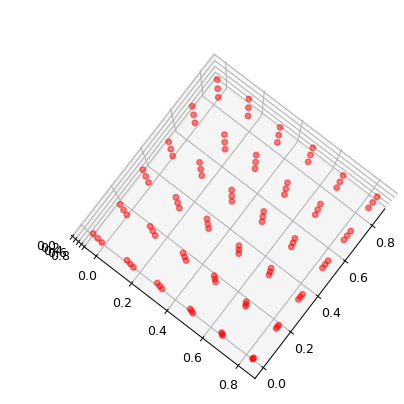

In [13]:
%matplotlib notebook
def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()
    return

draw_3d(origin_list[0][3])

Step 0, with MIN fitness 12.602273903683956, with MEAN fitness 19.034847981761423
Step 50, with MIN fitness 4.6483088828784735, with MEAN fitness 7.585235818109323
Step 100, with MIN fitness 3.214366737944015, with MEAN fitness 6.640245585524188
Step 150, with MIN fitness 3.056404105684509, with MEAN fitness 5.014053512466463
Step 200, with MIN fitness 3.056404105684509, with MEAN fitness 4.9089605380885475
Step 250, with MIN fitness 3.056404105684509, with MEAN fitness 4.853793771718823
Step 300, with MIN fitness 3.056404105684509, with MEAN fitness 4.778892851145181
Step 350, with MIN fitness 3.0450283540122514, with MEAN fitness 4.104147736276042
Step 400, with MIN fitness 3.0450283540122514, with MEAN fitness 4.034488376313117
Step 450, with MIN fitness 3.0450283540122514, with MEAN fitness 3.9565047582064308
Step 500, with MIN fitness 3.0450283540122514, with MEAN fitness 3.9374665976980925
Step 550, with MIN fitness 3.0450283540122514, with MEAN fitness 3.9271374489211266
Step 60

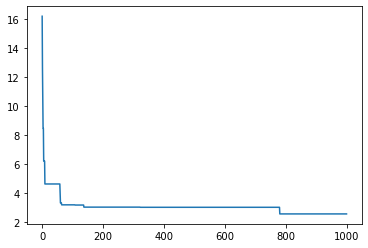

In [95]:
#preparation
plot_fit, fitness, len_fitlist = [], [], []
fitness_mean = []
fitness_b1, fitness_b2, fitness_b3, fitness_b4, fitness_b5, fitness_b6, fitness_b7, fitness_b8 = [],[],[],[],[],[],[],[]
fitness_partial_all = {}
for i1 in range(len(origin_list)):
    #将indb转化为concatenate形式
    cr_ind_b1, cr_res_b1 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_1')
    co_ind_b1, co_res_b1 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_1')
    ni_ind_b1, ni_res_b1 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_1')
    ind_b1 = combin_ele(cr_ind_b1, co_ind_b1, ni_ind_b1)
    
    cr_ind_b2, cr_res_b2 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_2')
    co_ind_b2, co_res_b2 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_2')
    ni_ind_b2, ni_res_b2 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_2')
    ind_b2 = combin_ele(cr_ind_b2, co_ind_b2, ni_ind_b2)
    
    cr_ind_b3, cr_res_b3 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_3')
    co_ind_b3, co_res_b3 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_3')
    ni_ind_b3, ni_res_b3 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_3')
    ind_b3 = combin_ele(cr_ind_b3, co_ind_b3, ni_ind_b3)
    
    cr_ind_b4, cr_res_b4 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_4')
    co_ind_b4, co_res_b4 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_4')
    ni_ind_b4, ni_res_b4 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_4')
    ind_b4 = combin_ele(cr_ind_b4, co_ind_b4, ni_ind_b4)
    
    cr_ind_b5, cr_res_b5 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_5')
    co_ind_b5, co_res_b5 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_5')
    ni_ind_b5, ni_res_b5 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_5')
    ind_b5 = combin_ele(cr_ind_b5, co_ind_b5, ni_ind_b5)
    
    cr_ind_b6, cr_res_b6 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_6')
    co_ind_b6, co_res_b6 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_6')
    ni_ind_b6, ni_res_b6 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_6')
    ind_b6 = combin_ele(cr_ind_b6, co_ind_b6, ni_ind_b6)
    
    cr_ind_b7, cr_res_b7 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_7')
    co_ind_b7, co_res_b7 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_7')
    ni_ind_b7, ni_res_b7 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_7')
    ind_b7 = combin_ele(cr_ind_b7, co_ind_b7, ni_ind_b7)
    
    cr_ind_b8, cr_res_b8 = cell_split(origin_list[i1][0], 1/2, 1/3, mode='block_8')
    co_ind_b8, co_res_b8 = cell_split(origin_list[i1][1], 1/2, 1/3, mode='block_8')
    ni_ind_b8, ni_res_b8 = cell_split(origin_list[i1][2], 1/2, 1/3, mode='block_8')
    ind_b8 = combin_ele(cr_ind_b8, co_ind_b8, ni_ind_b8)
    
    gen = genetic(origin_list[i1], cr_content, co_content)
    gen_b1 = genetic(ind_b1, cr_content, co_content)
    gen_b2 = genetic(ind_b2, cr_content, co_content)
    gen_b3 = genetic(ind_b3, cr_content, co_content)
    gen_b4 = genetic(ind_b4, cr_content, co_content)
    gen_b5 = genetic(ind_b5, cr_content, co_content)
    gen_b6 = genetic(ind_b6, cr_content, co_content)
    gen_b7 = genetic(ind_b7, cr_content, co_content)
    gen_b8 = genetic(ind_b8, cr_content, co_content)
    
    fit_whole = gen.fitness_whole()[0]
    fit_b1 = gen_b1.fitness_partial()[0]
    fit_b2 = gen_b2.fitness_partial()[0]
    fit_b3 = gen_b3.fitness_partial()[0]
    fit_b4 = gen_b4.fitness_partial()[0]
    fit_b5 = gen_b5.fitness_partial()[0]
    fit_b6 = gen_b6.fitness_partial()[0]
    fit_b7 = gen_b7.fitness_partial()[0]
    fit_b8 = gen_b8.fitness_partial()[0]
    fitness.append(fit_whole)
    fitness_b1.append(fit_b1)
    fitness_b2.append(fit_b2)
    fitness_b3.append(fit_b3)
    fitness_b4.append(fit_b4)    
    fitness_b5.append(fit_b5)    
    fitness_b6.append(fit_b6)
    fitness_b7.append(fit_b7)
    fitness_b8.append(fit_b8)   
    
fitness_partial_all['block_1'] = fitness_b1
fitness_partial_all['block_2'] = fitness_b2
fitness_partial_all['block_3'] = fitness_b3
fitness_partial_all['block_4'] = fitness_b4
fitness_partial_all['block_5'] = fitness_b5
fitness_partial_all['block_6'] = fitness_b6
fitness_partial_all['block_7'] = fitness_b7
fitness_partial_all['block_8'] = fitness_b8

start = time.time()
for kkt in range(1000):
    fitness_mean.append(np.mean(fitness))
    len_fit = len(fitness)

    plot_fit.append(np.min(fitness))
    #set prob for chosing accroding to the fitness_whole
    prob_list = np.array([(1/(fitness[i3]/np.sum(fitness)))**4 for i3 in range(len(fitness))])
    prob_list = (1-prob_list)/np.sum(1-prob_list)

    prob_list_neo = np.zeros(len(prob_list))
    for i4 in range(len(prob_list)):
        prob_list_neo[i4] = np.sum(prob_list[:i4+1])

    second_list = []
    
    god_dice = np.random.rand()
    prob_sign = np.sign(god_dice - prob_list_neo)
    god_chosen_ind = np.where(prob_sign == -1)[0][0]#the chosen index
    god_chose = origin_list[god_chosen_ind]#Anchoring the list
    
    mode_list = ['block_1', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6', 'block_7', 'block_8']
    for mode_chose in range(len(mode_list)):
        mode = mode_list[mode_chose]
        fitness_partial = fitness_partial_all[mode]#a comprehensive fitness_partial dic
        
        cr_ind, cr_res = cell_split(god_chose[0], 1/2, 1/3, mode=mode)
        co_ind, co_res = cell_split(god_chose[1], 1/2, 1/3, mode=mode)
        ni_ind, ni_res = cell_split(god_chose[2], 1/2, 1/3, mode=mode)
        ind = combin_ele(cr_ind, co_ind, ni_ind)
        res = combin_ele(cr_res, co_res, ni_res)

        #inner loop
        for partial_trial1 in range(5):
            gen = genetic(ind, cr_content, co_content)
            mut = gen.mutation_partial(repeat_time=int(kkt/80+5))#the mutation
            gen_mut = genetic(mut, cr_content, co_content)
            fit = gen_mut.fitness_partial()[0]
            #if <: take new
            if (fit < np.mean(fitness_partial)):
    #             mut_k = mut.copy()
    #             origin.append(mut1_k)
                fitness_partial.append(fit)
                #add new b1 to original cell, and use this new 'god_chose' for next iter.
                god_chose = comb_multi(mut, res)
                gen_whole = genetic(god_chose, cr_content, co_content)
                fit_whole = gen_whole.fitness_whole()[0]
                if (fit_whole <= np.mean(fitness)
                    and np.linalg.norm(np.array(god_chose[3])-np.array(origin_list[-1][3])) > 0):
                    origin_list.append(god_chose)
                    fitness.append(fit_whole)
                #mut for the new god-chose
                for partial_trial2 in range(5):
                    mut_whole = gen_whole.mutation(repeat_time=int(kkt/80+5))#whole mutation
                    gen_mut_whole = genetic(mut_whole, cr_content, co_content)
                    fit_mut_whole = gen_mut_whole.fitness_whole()[0]
                    if (fit_mut_whole <= np.mean(fitness)
                        and np.linalg.norm(np.array(mut_whole[3])-np.array(origin_list[-1][3])) > 0):
                        origin_list.append(mut_whole)
                        fitness.append(fit_mut_whole)
                fitness_partial_all[mode] = fitness_partial
                
    #get new origin_list and deduce their fitness,
    #new fitness_whole and origin_list_whole sequence are generated
    if len(fitness) >= 200:
        new_type = []
        new_type_ind = np.where(fitness <= np.mean(fitness))[0]
        if len(new_type_ind) >= 10:
            for nt in new_type_ind:
                new_type.append(origin_list[nt])
            origin_list = new_type.copy()
            fitness = []
            for ifit in range(len(origin_list)):
                fit1 = Fitness(origin_list[ifit], cr_content, co_content)[0]
                fitness.append(fit1)
                
    if kkt % 50 == 0:
        len_fitlist.append(len(fitness))
        
    min_fitness = np.min(fitness)
    if kkt % 50 == 0:
        print(f'Step {kkt}, with MIN fitness {min_fitness}, with MEAN fitness {np.mean(fitness)}')
    
plt.plot(plot_fit)
content = f'job MSAD genetic comp. Cr{cr_content*100}Co{co_content*100}Ni{ni_content*100} complete.\n'
mail_auto.auto_mail(content)
end = time.time()
second_to_hour(end - start)

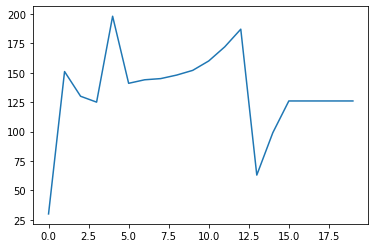

In [83]:
plt.plot(len_fitlist)

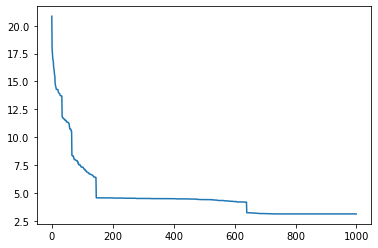

In [84]:
plt.plot(fitness_mean)

In [104]:
ind_best = np.where(fitness <= np.min(fitness)+0.7)[0]
ind_best

array([ 20,  48,  49,  52,  53,  54,  55,  61,  62,  63,  64,  75,  76,
        83,  87,  88,  89,  90,  93,  94,  95,  96, 110, 111, 114, 115,
       116, 117, 120, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133,
       134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 151, 152, 153, 154, 155, 157, 158, 159, 162, 163, 166,
       167, 169, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184],
      dtype=int64)

In [96]:
print(cr_content, co_content)

0.9 0.05


In [114]:
fit_ratio = []
for i in ind_best:
    gen = genetic(origin_list[i], cr_content, co_content)
    fit_ratio.append(round(gen.fitness_whole()[1], 5))
    
fit_ratio

[0.15941, 0.14205, 0.14966, 0.15941, 0.14606, 0.14341, 0.15941, 0.1458]

In [115]:
ind_best = np.delete(ind_best, np.where(np.array(fit_ratio) == 0.15941)[0][1:])

In [116]:
ind_best

array([ 20,  48,  61, 117, 172, 179], dtype=int64)

In [117]:
for i in range(len(ind_best)):
    index_chosen = ind_best[i]
    name = 'Cr90Co5Ni5'
    trial = 1+i
    create_dir(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name}_try{trial}')
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name}_try{trial}/{name}_cr_chosen.npy', 
            origin_list[index_chosen][0])
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name}_try{trial}/{name}_co_chosen.npy', 
            origin_list[index_chosen][1])
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name}_try{trial}/{name}_ni_chosen.npy', 
            origin_list[index_chosen][2])

Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr90Co5Ni5_try1
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr90Co5Ni5_try2
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr90Co5Ni5_try3
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr90Co5Ni5_try4
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr90Co5Ni5_try5
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr90Co5Ni5_try6


In [4]:
def bash_cp(n, file):
    srcdir = f'/home/wang/runx{n}.sh'
    dstdir = file + f'/runx{n}.sh'

    srcfile = os.path.join(srcdir)
    dstfile = os.path.join(dstdir)
    shutil.copyfile(srcfile, dstfile)

    split_pattern = '[/\\\_]'
    type_dir = re.split(split_pattern, file)
    jobname = 't'+list(type_dir[-1])[-1]+type_dir[-5]

    with open(dstdir, 'w') as rsh:
        rsh.write(f'''\
#!bin/sh
#$ -cwd
#$ -V -S /bin/bash
#$ -N {jobname}
#$ -pe smp {n}
#$ -q x{n}
mpirun -np {n} vasp
    ''')
        

def write_input(output_dir, param, cell_num, cr_content, co_content, kpt, n, 
                cr_position_try, co_position_try, ni_position_try
               ):
    incar1 = {
        'ISTART' : 0,
        'ICHARG' : 2,
        'ENCUT' : 450,
        'ALGO' : 'Normal',
        'NELM' : 60,
        'EDIFF' : 1e-07,
        'ISMEAR' : 1,
        'SIGMA' : 0.1,
        'PREC' : 'Accurate',
        'POTIM' : 0.2,
        'ISIF' : 2,
        'NSW' : 500,
        'IBRION' : 2,
        'LREAL' : 'Auto',
        'EDIFFG' : 0.001,
        'LPLANE' : '.TRUE.',
        'LSCALU' : '.FALSE.',
        'LWAVE' : '.FALSE.'
    }
    #4:8*8*4
    #3:6*6*3
    ni_content = 1 - cr_content - co_content
    incar1 = vasp.Incar(incar1)
    true_num = (cell_num*2)**3/2
    
    cr_position = delete1(cr_position_try)
    co_position = delete1(co_position_try)
    ni_position = delete1(ni_position_try)
    
    specie = [{'Cr0+':1}]*len(cr_position) + [{'Co0+':1}]*len(co_position) + [{'Ni0+':1}]*len(ni_position)
    position1 = np.insert(cr_position, len(cr_position), co_position, axis = 0)
    position = np.insert(position1, len(position1), ni_position, axis = 0)
    position = position.reshape(len(position), 3)
    #print(position)
    #POSCAR
    #lattice_constant = 17.5
    param1 = param * cell_num
    lattice = Lattice.from_parameters(a = param1, b = param1, c = param1, 
                                      alpha = 90, beta = 90, gamma = 90)
    #lattice = mg.Lattice(lattice)

    struct = Structure(
        lattice,
        specie,
        position
    )
    poscar = vasp.Poscar(struct, comment = 'SQS CrCoNi')

    #POTCAR
    potcar = Potcar(symbols = ['Cr_pv_new', 'Co_pv', 'Ni_pv'], functional = 'PBE')
    
    #K-Points
    kpoints = Kpoints(num_kpts=0, style="Monkhorst-Pack", kpts=((kpt, kpt, kpt), ),
                      kpts_shift=(0, 0, 0))

    vaspinput = VaspInput(incar1, kpoints, poscar, potcar)
    vaspinput.write_input(output_dir)
    bash_cp(n, output_dir)
    return [cr_position, co_position, ni_position]

In [143]:
file = '/home/wang/MSAD/OUTPUTS/Cr40Co30Ni30/Cr40Co30Ni30_3_518_4_try38'
_=write_input(file, 3.518, 4, 0.4, 0.3, 2, 52, num_tri=504, num_tetra=126)

ideal:[102.4, 76.8, 76.8]
Cr, Co, Ni: [103, 77, 76]
variance: 0.35
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!


In [ ]:
def ideal_entro(k, m):
    n = 1 - k - m
    entro_spin = -5*(k*math.log(k) + m*math.log(m) + n*math.log(n))
    entro_bond = 6*(k**2*math.log(k**2)
                   + 2*k*m*math.log(2*k*m)
                   + m**2*math.log(m**2)
                   + 2*m*n*math.log(2*m*n)
                   + n**2*math.log(n**2)
                   + 2*n*k*math.log(2*n*k))
    entro_tetra = -2*(4*(k**3)*m*math.log(4*(k**3)*m)
                     + 4*(k**3)*n*math.log(4*(k**3)*n)
                     + 4*(m**3)*n*math.log(4*(m**3)*n)
                     + 4*(m**3)*k*math.log(4*(m**3)*k)
                     + 4*(n**3)*m*math.log(4*(n**3)*m)
                     + 4*(n**3)*k*math.log(4*(n**3)*k)
                     + 6*(k**2)*(m**2)*math.log(6*(k**2)*(m**2))
                     + 6*(n**2)*(m**2)*math.log(6*(n**2)*(m**2))
                     + 6*(k**2)*(n**2)*math.log(6*(k**2)*(n**2))
                     + 12*(k**2)*m*n*math.log(12*(k**2)*m*n)
                     + 12*(m**2)*k*n*math.log(12*(m**2)*k*n)
                     + 12*(n**2)*m*k*math.log(12*(n**2)*m*k))
    entro_all = entro_spin + entro_bond + entro_tetra
    return entro_all

ideal_config_entro = ideal_entro(1/3, 1/3)
ideal_config_entro

In [ ]:
if __name__ == '__main__':
    for i in np.linspace(1, 10, 10):
        dir_in = '/home/Wang/CrCoNi/CrCoNi_{}'.format(int(i))
        write_input(dir_in)

In [39]:
def dup_remov(a):
    sorted_idx = np.lexsort(a.T)
    sorted_a =  a[sorted_idx,:]
    row_mask = np.append([True],np.any(np.diff(sorted_a,axis=0),1))
    out = sorted_a[row_mask]
    return out
    print(len(out))

In [72]:
cr_position, co_position, ni_position, ind = gen_crconi()
cr_position = delete_1(cr_position)
co_position = delete_1(co_position)
ni_position = delete_1(ni_position)
len(ni_position)

169

In [30]:
#cr=1, co=0, ni=-1
#two - consider 3 condition
#three - just need on considerision
def f12(centr, nn):
    return cpr(centr, nn)*12

def f11p1(centr, nn1, nn2):
    f = cpr(centr, nn1)*11 + cpr(centr, nn2)
    return f

def f10p2(centr, nn1, nn2):
    f = cpr(centr, nn1)*10 + cpr(centr, nn2)*2
    return f

def f10p1p1(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*10 + cpr(centr, nn3) + cpr(centr, nn2)
    return f

def f9p3(centr, nn1, nn2):
    f = cpr(centr, nn1)*9 + cpr(centr, nn2)*3
    return f

def f9p2p1(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*9 + cpr(centr, nn2)*2 + cp2(centr, nn3)
    return f

def f8p4(centr, nn1, nn2):
    f = cpr(centr, nn1)*8 + cpr(centr, nn2)*4
    return f

def f8p3p1(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*8 + cpr(centr, nn2)*3 + cpr(centr, nn3)
    return f

def f8p2p2(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*8 + cpr(centr, nn2)*2 + cpr(centr, nn3)
    return f

def f7p5(centr, nn1, nn2):
    f = cpr(centr, nn1)*7 + cpr(centr, nn2)*5
    return f

def f7p4p1(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*7 + cpr(centr, nn2)*4 + cpr(centr, nn3)
    return f

def f7p3p2(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*7 + cpr(centr, nn2)*3 + cpr(centr, nn3)*2
    return f

def f6p6(centr, nn1, nn2):
    f = cpr(centr, nn1)*6 + cpr(centr, nn2)*6
    return f

def f6p5p1(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*6 + cpr(centr, nn2)*5 + cpr(centr, nn3)
    return f

def f6p4p2(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*6 + cpr(centr, nn2)*4 + cpr(centr, nn3)*2
    return f

def f6p3p3(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*6 + cpr(centr, nn2)*3 + cpr(centr, nn3)*3
    return f

def f5p5p2(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*5 + cpr(centr, nn2)*5 + cpr(centr, nn3)*2
    return f

def f5p4p3(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*5 + cpr(centr, nn2)*4 + cpr(centr, nn3)*3
    return f

def f4p4p4(centr, nn1, nn2, nn3):
    f = cpr(centr, nn1)*4 + cpr(centr, nn2)*4 + cpr(centr, nn3)*4
    
#count the ideal value
def sum_first_nn(k, m, n):
    #k - 1, m - 0, n - -1
    kr, mr, nr = k*0+1, m*0, n*0-1
    sum_cr_centr = (k**12*f12(1, kr)+m**12*f12(1, mr)+n**12*f12(1,nr)
                   +12*k**11*m*f11p1(1,kr,mr)+12*m**11*k*f11p1(1,mr,kr)+12*n**11*k*f11p1(1,nr,kr)
                   +12*k**11*n*f11p1(1,kr,nr)+12*m**11*n*f11p1(1,mr,nr)+12*n**11*m*f11p1(1,nr,mr)
                   +66*(k**10)*(n**2)*f10p2(1,kr,nr)+66*(m**10)*(n**2)*f10p2(1,mr,nr)+66*(n**10)*(m**2)*f10p2(1,nr,mr)
                   +66*(k**10)*(m**2)*f10p2(1,kr,mr)+66*(m**10)*(k**2)*f10p2(1,mr,kr)+66*(n**10)*(k**2)*f10p2(1,nr,kr)
                   +132*(k**10)*m*n*f10p1p1(1,kr,mr,nr)+132*(m**10)*k*n*f10p1p1(1,mr,kr,nr)+132*(n**10)*m*k*f10p1p1(1,nr,mr,kr)
                   +220*(k**9)*(m**3)*f9p3(1,kr,mr)+220*(m**9)*(k**3)*f9p3(1,mr,kr)+220*(n**9)*(m**3)*f9p3(1,nr,mr)
                   +220*(k**9)*(n**3)*f9p3(1,kr,nr)+220*(m**9)*(n**3)*f9p3(1,mr,nr)+220*(n**9)*(k**3)*f9p3(1,nr,kr)
                   )

In [2]:
unit6 = [[[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]]]

unit5 = [
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]]
    ]

unit4 = [
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]]
    ]

unit3 = [
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]]
]

unit2 = [
    [[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1]],
    [[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0]],
    [[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1]],
    [[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0]],
    [[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1]]
]